#Setup

In [ ]:
import string
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.utils import draw_bounding_boxes, draw_keypoints
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
from torchvision.models.detection.keypoint_rcnn import KeypointRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from PIL import Image
from pycocotools.coco import COCO
import os

device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_paths = {
    "Mark": "/content/drive/MyDrive/CIS5810/CIS581_FinalProject",
    "Brandon": "/content/drive/MyDrive/CIS581_FinalProject",
    "Wesley": "/content/drive/MyDrive/2022-2023/Sem1/CIS 581/CIS581_FinalProject",
    "Wesley(+)": "/content/drive/MyDrive/CIS 581/CIS581_FinalProject",
    "Ronil": "/content/drive/MyDrive/CIS581_FinalProject",
    "Guest": None
}

In [ ]:
#@title Choose User

user = 'Wesley(+)' #@param ["Mark", "Wesley", "Wesley(+)", "Ronil", "Brandon", "Guest"]

USER_PATH = root_paths[user]

In [ ]:
cd $USER_PATH

/content/drive/.shortcut-targets-by-id/12qLMU3_zRVqODctEEsdfy-FxGybb2i1D/CIS 581/CIS581_FinalProject


#Data Processing: Dataset and Dataloader + Feature Extraction

In [ ]:
!pip install cvzone
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for cvzone: filename=cvzone-1.5.6-py3-none-any.whl size=18767 sha256=72c14ffd010ae0264140245dd362c089a13849f0770e05325a49a70c381df5a2
  Stored in directory: /root/.cache/pip/wheels/67/60/9a/e5060027d8eae2c01ba872fdbc094a6fe3fee15794ee3dc709
Successfully built cvzone
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 136.1 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.


In [ ]:
import cvzone
from cvzone.HandTrackingModule import HandDetector
import cv2

In [ ]:
torch.rand(255, 255, 3).permute(2, 0, 1).shape

torch.Size([3, 255, 255])

In [ ]:
class ASLDataset(Dataset):
    def __init__(self, root, annotation):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.feature_extractor = HandDetector(maxHands=1, detectionCon=0, minTrackCon=0)
        self.hand_type_encoding = {
            "Right": torch.tensor([0, 1]).float(), 
            "Left": torch.tensor([1, 0]).float()
        }
        self.img_size = (256, 256)
        self.transform = T.Resize(self.img_size, InterpolationMode.BILINEAR)
    
    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(img_id)
        coco_annotation = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']

        labels = []
        for i in range(len(coco_annotation)):
            labels = torch.zeros(27)
            labels[coco_annotation[i]['category_id']] = 1
        
        cv_img = cv2.imread(os.path.join(self.root, path))
        img = self.transform(torch.from_numpy(cv_img).permute(2, 0, 1))
        fe = self.feature_extractor.findHands(cv_img, draw=False)[0]
        landmarks = torch.tensor(fe["lmList"])
        bbox = torch.tensor(fe["bbox"])
        hand_encoding = self.hand_type_encoding[fe["type"]]
        
        labels = torch.as_tensor(labels).float()
        
        features = {
            "landmarks": landmarks.float(),
            "bbox": bbox.float(),
            "hand_encoding": hand_encoding.float(),
            "img": img.float()
        }

        return features, labels

    def __len__(self):
        return len(self.ids)

dataset_path = "./Datasets/ASL-coco"
ann_file = "_annotations.coco.json"
asl_train_ds = ASLDataset(f"{dataset_path}/train", f"{dataset_path}/train/{ann_file}")
asl_test_ds = ASLDataset(f"{dataset_path}/test", f"{dataset_path}/test/{ann_file}")
asl_val_ds = ASLDataset(f"{dataset_path}/valid", f"{dataset_path}/valid/{ann_file}")

train_dl = DataLoader(asl_train_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(asl_test_ds, batch_size=16)
val_dl = DataLoader(asl_val_ds, batch_size=16)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


#Models

##Simple CNN Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self, c1=96, c2= 192, out_feat=27):
        super().__init__()

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.b1 = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1)
        )
        self.b2 = nn.Sequential(
            nn.Dropout(.5),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1)
        )
        self.b3 = nn.Sequential(
            nn.Dropout(.5),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,out_feat,1,1),
            nn.AvgPool2d(8)
        )
        self.lin = nn.Sequential(
            nn.Linear(out_feat * 8 * 8, 216),
            nn.ReLU(),
            nn.Linear(216, 64),
            nn.ReLU(),
            nn.Linear(64, out_feat)
        )

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = x.flatten(start_dim=1)
        x = self.lin(x)
        return x

##Deep Linear Network: Hand Feature Estimation / Landmark Estimation

In [ ]:
class DLN(nn.Module):
    num_landmarks = 21
    num_classes = 27

    def __init__(self):
        super(DLN, self).__init__()
        self.lm_norm = nn.InstanceNorm1d(3, affine=True) #Instance Norm By X, Y, Z Channel
        self.lm_lin = nn.Linear(self.num_landmarks * 3, 128)
        self.bb_enc_lin = nn.Linear(6, 32)

        self.lin_cat = nn.Linear(32 + 128, 64)
        self.fin_lin = nn.Linear(64, self.num_classes)
    
    def forward(self, lm, bb, enc):
        lm = self.lm_norm(lm.permute(0, 2, 1)).permute(0, 2, 1)
        lm = lm.flatten(start_dim=1)
        l1 = F.relu(self.lm_lin(lm))

        bb_enc = torch.cat([bb, enc], dim=1)
        l2 = F.relu(self.bb_enc_lin(bb_enc))

        cat = torch.cat([l1, l2], dim=1)
        l3 = F.relu(self.lin_cat(cat))
        
        out = self.fin_lin(l3)
        return out

##Composite Model

In [ ]:
class DLN_CNN(nn.Module):
    def __init__(self):
        super(DLN_CNN, self).__init__()
        self.dln_model = DLN()
        self.cnn_model = CNN(out_feat=50)
        self.lin_block = nn.Sequential(
            nn.Linear(77, 32),
            nn.ReLU(),
            nn.Linear(32, 27)
        )
    
    def forward(self, lm, bb, enc, img):
        cnn_feats = self.cnn_model(img)
        dln_feats = self.dln_model(lm, bb, enc)
        out = torch.cat((cnn_feats, dln_feats), dim=1)
        out = self.lin_block(out)
        return out

#Training, Validation, and Test Methods

In [ ]:
def get_corr(preds, y):
    cat_preds = torch.argmax(preds, dim=1)
    y_lab = torch.argmax(y, dim=1)
    num_corr = (cat_preds == y_lab).sum().item()
    return num_corr

In [ ]:
def train_test(model, optimizer, criterion, epochs, feat_names):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for e in range(epochs):
        running_loss = 0.0
        running_acc = 0.0
        num_samples = 0
        for feat, lab in train_dl:
            features = []
            for feat_name in feat_names:
                features.append(feat[feat_name].to(device))
            lab = lab.to(device)

            optimizer.zero_grad()
            preds = model(*features)
            loss = criterion(preds, lab)
            loss.backward()
            optimizer.step()

            num_samples += lab.shape[0]
            running_loss += loss.item()
            running_acc += get_corr(preds, lab)
            
        train_loss.append(running_loss)
        train_acc.append(running_acc / num_samples)
        print(f"Epoch {e + 1}" + "=" * 50)
        print(f"Train Loss: {running_loss} || Train Acc: {running_acc / num_samples}")

        running_loss = 0.0
        running_acc = 0.0
        num_samples = 0
        with torch.no_grad():
            for feat, lab in val_dl:
                features = []
                for feat_name in feat_names:
                    features.append(feat[feat_name].to(device))
                lab = lab.to(device)
                
                preds = model(*features)
                loss = criterion(preds, lab)
                
                num_samples += lab.shape[0]
                running_loss += loss.item()
                running_acc += get_corr(preds, lab)
        val_loss.append(running_loss)
        val_acc.append(running_acc / num_samples)

        print(f"Val Loss: {running_loss} || Val Acc: {running_acc / num_samples}")
    running_loss = 0.0
    running_acc = 0.0
    num_samples = 0
    with torch.no_grad():
        for feat, lab in test_dl:
            features = []
            for feat_name in feat_names:
                features.append(feat[feat_name].to(device))
            lab = lab.to(device)
            preds = model(*features)
            loss = criterion(preds, lab)
            
            num_samples += lab.shape[0]
            running_loss += loss.item()
            running_acc += get_corr(preds, lab)
    test_acc = running_acc / num_samples
    test_loss = running_loss / num_samples

    return train_loss, train_acc, val_loss, val_acc, test_acc, test_loss

#Comparing Model Performance

##Deep Linear Network

In [ ]:
epochs = 50
dln_model = DLN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dln_model.parameters(), lr=1e-2, momentum=.5)

In [ ]:
train_loss, train_acc, val_loss, val_acc, test_acc, test_loss = train_test(dln_model, optimizer, criterion, epochs, ["landmarks", "bbox", "hand_encoding"])

Epoch 1==================================================
Train Loss: 387.86775398254395 || Train Acc: 0.025793650793650792
Val Loss: 47.17757701873779 || Val Acc: 0.034722222222222224
Epoch 2==================================================
Train Loss: 312.97665309906006 || Train Acc: 0.037037037037037035
Val Loss: 47.35419273376465 || Val Acc: 0.034722222222222224
Epoch 3==================================================
Train Loss: 312.46246361732483 || Train Acc: 0.051587301587301584
Val Loss: 47.551100730895996 || Val Acc: 0.034722222222222224
Epoch 4==================================================
Train Loss: 312.06016755104065 || Train Acc: 0.051587301587301584
Val Loss: 47.698750495910645 || Val Acc: 0.034722222222222224
Epoch 5==================================================
Train Loss: 311.7186107635498 || Train Acc: 0.051587301587301584
Val Loss: 47.84533452987671 || Val Acc: 0.034722222222222224
Epoch 6==================================================
Train Loss: 311.

In [ ]:
print("Test Acc: ", test_acc, " , Test Loss: ", test_loss)

Test Acc:  0.013888888888888888  , Test Loss:  0.33332645893096924


In [ ]:
torch.save(dln_model.state_dict(), os.path.join(USER_PATH, "SavedModels", "dln_model.pt"))

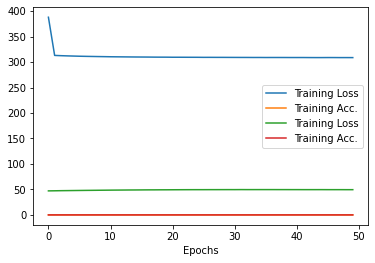

In [ ]:
plt.xlabel("Epochs")
plt.plot(train_loss, label="Training Loss")
plt.plot(train_acc, label="Training Acc.")
plt.plot(val_loss, label="Training Loss")
plt.plot(val_acc, label="Training Acc.")
plt.legend()

##CNN Architecture

In [ ]:
epochs = 50
cnn_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-3)

In [ ]:
train_loss, train_acc, val_loss, val_acc, test_acc, test_loss = train_test(cnn_model, optimizer, criterion, epochs, ["img"])

Epoch 1==================================================
Train Loss: 309.00116991996765 || Train Acc: 0.07407407407407407
Val Loss: 28.564648389816284 || Val Acc: 0.09722222222222222
Epoch 2==================================================
Train Loss: 286.5047335624695 || Train Acc: 0.13955026455026456
Val Loss: 26.379728317260742 || Val Acc: 0.14583333333333334
Epoch 3==================================================
Train Loss: 256.3155413866043 || Train Acc: 0.2156084656084656
Val Loss: 25.460208892822266 || Val Acc: 0.2222222222222222
Epoch 4==================================================
Train Loss: 231.49949061870575 || Train Acc: 0.2724867724867725
Val Loss: 24.63140106201172 || Val Acc: 0.2222222222222222
Epoch 5==================================================
Train Loss: 205.83189988136292 || Train Acc: 0.3406084656084656
Val Loss: 25.824130296707153 || Val Acc: 0.2222222222222222
Epoch 6==================================================
Train Loss: 179.22207355499268 

In [ ]:
print("Test Acc: ", test_acc, " , Test Loss: ", test_loss)

Test Acc:  0.2222222222222222  , Test Loss:  0.43101752466625637


In [ ]:
torch.save(cnn_model.state_dict(), os.path.join(USER_PATH, "SavedModels", "cnn_model.pt"))

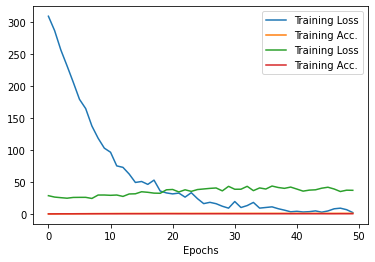

In [ ]:
plt.xlabel("Epochs")
plt.plot(train_loss, label="Training Loss")
plt.plot(train_acc, label="Training Acc.")
plt.plot(val_loss, label="Training Loss")
plt.plot(val_acc, label="Training Acc.")
plt.legend()

##Composite Model

In [ ]:
epochs = 50
comp_model = DLN_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(comp_model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-3)

In [ ]:
train_loss, train_acc, val_loss, val_acc, test_acc, test_loss = train_test(comp_model, optimizer, criterion, epochs, ["landmarks", "bbox", "hand_encoding", "img"])

Epoch 1==================================================
Train Loss: 315.3055703639984 || Train Acc: 0.037037037037037035
Val Loss: 29.700680017471313 || Val Acc: 0.05555555555555555
Epoch 2==================================================
Train Loss: 311.6412138938904 || Train Acc: 0.04828042328042328
Val Loss: 29.72341799736023 || Val Acc: 0.05555555555555555
Epoch 3==================================================
Train Loss: 310.7499647140503 || Train Acc: 0.051587301587301584
Val Loss: 29.744107723236084 || Val Acc: 0.05555555555555555
Epoch 4==================================================
Train Loss: 310.2390546798706 || Train Acc: 0.046957671957671955
Val Loss: 29.783730506896973 || Val Acc: 0.05555555555555555
Epoch 5==================================================
Train Loss: 309.88575863838196 || Train Acc: 0.051587301587301584
Val Loss: 29.801187753677368 || Val Acc: 0.05555555555555555
Epoch 6==================================================
Train Loss: 309.6772236

In [ ]:
print("Test Acc: ", test_acc, " , Test Loss: ", test_loss)

Test Acc:  0.027777777777777776  , Test Loss:  0.2287255823612213


In [ ]:
torch.save(comp_model.state_dict(), os.path.join(USER_PATH, "SavedModels", "comp_model.pt"))

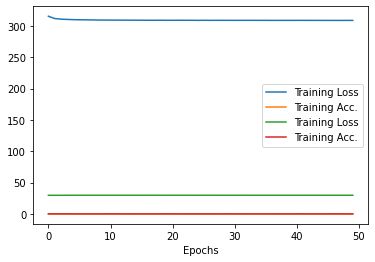

In [ ]:
plt.xlabel("Epochs")
plt.plot(train_loss, label="Training Loss")
plt.plot(train_acc, label="Training Acc.")
plt.plot(val_loss, label="Training Loss")
plt.plot(val_acc, label="Training Acc.")
plt.legend()